# So how do we fit the models from practical perspective?

In the previous lecture we discussed the very basics of statistics, and even showed how numerical minimization of $\chi^2$ function can be used to fit a model to the data. Of course, it is not particularly practical to repeat this excercise every time you need to fit something, so let's discuss convinient options to do fitting. Of course, there are many! You can use i.e. MS Excel, Origin, matlab or whatever. Here we discuss only *python* options.

To illustrate how to fit the data, we must first generate some mock dataset, let's start with the simplest (i.e. linear) option. Basically, our task for today is to generate a line, and then fit it with several methods. It is easier to think in terms of model and data, so let's define our model and data. We will also always think in terms of dependent and independent variales, i.e. *x,y*

<ErrorbarContainer object of 3 artists>

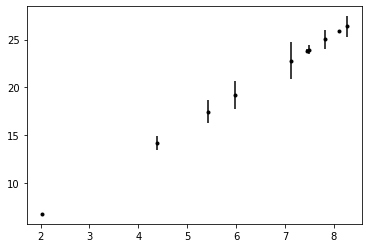

In [1]:
from numpy import *
import pylab as pl

# define the model
model = lambda p, x: p[0]+p[1]*x
# independent variable
x = random.uniform(0,10,10)
x.sort()
# and dependent variable ("ground truth")
intercept0,slope0 = 1.3,3.15
y0 = model([intercept0,slope0],x)
# and now, let's introduce some stochastical fluctuations to it
y = y0+random.normal(loc=0,scale=1)
ye = random.normal(loc=0,scale=1,size=len(y))
pl.errorbar(x,y,ye,fmt='k.')

Now, the easiest way to fit this *particular* data is to use *polyfit* function from *numpy*

Best-fit intercept=0.37 slope=3.15 (input was 1.30 and 3.15)


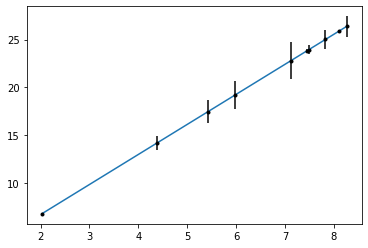

In [2]:
p = polyfit(x,y,1)
print("Best-fit intercept=%.2f slope=%.2f (input was %.2f and %.2f)"%(p[1],p[0],intercept0,slope0))
pl.errorbar(x,y,ye,fmt='k.')
pl.plot(x,polyval(p,x))

There's no way to get an idea on uncertainty of best-fit parameters in this case, however, to do that, we'd need to go back, and repeat what we did already in the first part of the lecture (projection etc), i.e. do direct minimization of $\chi^2$ and then calculate change of parameter of interest corresponding to expected $\Delta\chi^2$ for desired level of confidence. We'll not do that again. Instead, let's use another useful package called *sherpa* which is actually designed for fitting of *Chandra* spectra. This package has a bunch of models built-in, so for most cases you can find a suitable one

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find xpaget on your PATH'
Dataset               = 1
Method                = levmar
Statistic             = chi2
Initial fit statistic = 87478.5
Final fit statistic   = 1.40778e-27 at function evaluation 7
Data points           = 10
Degrees of freedom    = 8
Probability [Q-value] = 1
Reduced statistic     = 1.75973e-28
Change in statistic   = 87478.5
   pp.c0          0.368458     +/- 0.0597641   
   pp.c1          3.15         +/- 0.0179523   


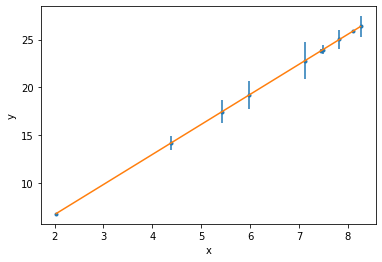

In [3]:
import sherpa.astro.ui as ui
ui.load_arrays(1,x,y,ye)
ui.set_model(1,ui.polynom1d.pp)
ui.thaw(pp.c1)
ui.fit()
ui.plot_fit()

You can also use *ui.conf* and *ui.proj* methods (different implementation of the same idea) to calculate errors on best-fit parameters similar to what we did manually before. Don't forget to set desired confidence level!  

In [4]:
ui.set_conf_opt('sigma',3)
ui.conf(pp.c0,pp.c1)

pp.c0 lower bound:	-0.179292
pp.c1 lower bound:	-0.053857
pp.c0 upper bound:	0.179292
pp.c1 upper bound:	0.053857
Dataset               = 1
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = chi2gehrels
confidence 3-sigma (99.73%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   pp.c0            0.368458    -0.179292     0.179292
   pp.c1                3.15    -0.053857     0.053857


*sherpa* also includes most of spectral models form *Xspec* which we'll discuss later in the course, and lots of other stuff, but still it may be that you need a bit more flexibility. In this case you can define your model. Obviously, in our case result will be the same, but you can use *any* python function (or even wrap some fortran/c code)

Dataset               = 1
Method                = levmar
Statistic             = chi2
Initial fit statistic = 38855.3
Final fit statistic   = 1.34724e-27 at function evaluation 7
Data points           = 10
Degrees of freedom    = 8
Probability [Q-value] = 1
Reduced statistic     = 1.68405e-28
Change in statistic   = 38855.3
   mymodel.intercept   0.368458     +/- 0.0597641   
   mymodel.slope   3.15         +/- 0.0179523   


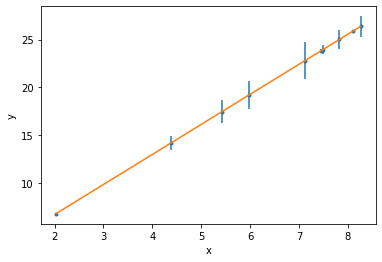

In [5]:
ui.load_user_model(model,'mymodel')
ui.add_user_pars('mymodel',['intercept','slope'],[1,1])
ui.set_model(1,mymodel)
ui.fit()
ui.plot_fit()

In [6]:
ui.conf()

mymodel.intercept lower bound:	-0.179292
mymodel.slope lower bound:	-0.053857
mymodel.intercept upper bound:	0.179292
mymodel.slope upper bound:	0.053857
Dataset               = 1
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = chi2gehrels
confidence 3-sigma (99.73%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   mymodel.intercept     0.368458    -0.179292     0.179292
   mymodel.slope         3.15    -0.053857     0.053857


You can also make nice countour plots like we did before, both for one or two parameters of interest. Here in first case value of your statistics is plotted as a function of parameter value, and in 2nd case contour plots with levels corresponding by default to 1,2,3$\sigma$ is displayed (you can change that)

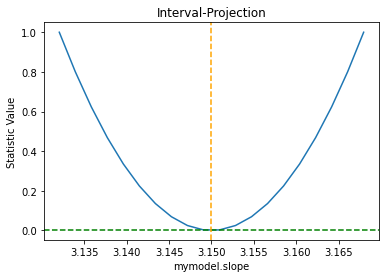

In [7]:
ui.int_proj(mymodel.slope)

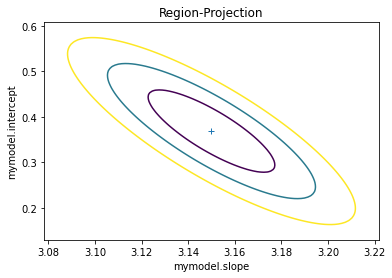

In [8]:
ui.reg_proj(mymodel.slope,mymodel.intercept,nloop=(100,100))

The later option is quite useful when you want to explore interdependence between parameters of your model. Keep in mind that often those will be quite complex, so in principle you need to look in all combinations of your parameters! It is a good practice to check those contours whenever you do a fit, especially if model is not a line!

Now, one limitation of *sherpa* is that it is designed to work mainly with X-ray spectral data, which is most often represented as number of counts per energy bin. That, in turn, represents integral of a model over each energy bin (which has precisely defined edges), and that sherpa does really well. However, it means that there's no way to account for uncertainties in your *independent* variable. That's actually true also for normal $\chi^2$ minimization we discussed before. So what to do when also your independent variable? Well, that's complex issue. First of all, does it matter? If you have very small uncertainties for one of the variables, probably not, but often those can be substantial. One of the easiest ways to account for that is use *total least squares*  regression (also known as *Deming* or *orthogonal* for specific cases) implemented in *scipy.odr* module. Will not discuss math here, but the basic difference of ODR  wrt. normal $\chi^2$ is illustrated by this picture:

![ODR](https://i.stack.imgur.com/83Jog.png)

so let's illustrate how it works with the same dataset but with *x* also having some errors

Best-fit intercept=2.96 slope=2.61 (input was 1.30 and 3.15)
Estimated uncertainty for best-fit parameters [2.59313508 0.32557846]


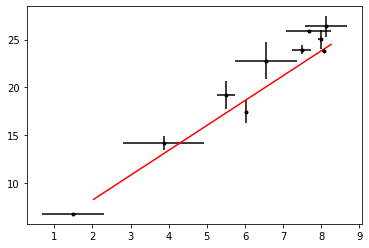

In [9]:
from scipy.odr import RealData, Model, ODR

x1 = x + random.normal(loc=0,scale=0.5,size=len(x))
xe = random.normal(loc=0,scale=0.5,size=len(x))

mymodel = Model(model)
mydata = RealData(x1,y,sy=ye,sx=xe)
myodr = ODR(mydata,mymodel,beta0=[1,1]) # beta0 is initial guess for your parameters
myoutput = myodr.run()

pl.errorbar(x1,y,ye,xe,fmt='k.')
pl.plot(x,model(myoutput.beta,x),'r-')
print("Best-fit intercept=%.2f slope=%.2f (input was %.2f and %.2f)"%(myoutput.beta[0],myoutput.beta[1],intercept0,slope0))
print("Estimated uncertainty for best-fit parameters",myoutput.sd_beta)

Note that estimated uncertainties do not correspond to what you would get via projection method discussed above (i.e. compare uncertainties calculated by sherpa with ODR). That's because ODR is still a variation of least squares and thus the uncertainties come from covariance matrix which is the simplest but inaccurate way to take inter-dependence of parameters into the account (we did not discuss this, I know, but read the *modern methods* book!). Anyway, now, it is suitable time to note that **uncertainties in the data** are reflected in **uncertainty of the best-fit model**, which brings us to a philosophycal question dividing astronomical community when it comes to statistics. 

To illustrate what I mean, let me plot the above another time, but now trying to simulate not only data, but also predicted model points (based one stimated uncertainties, and those could be as well estimated by projection!). What you see are all possible realizations of the model, when uncertainties in model parameters (inevitable if you have to use any of the statistics) are taken into the account

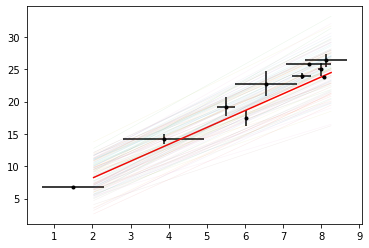

In [10]:
pl.errorbar(x1,y,ye,xe,fmt='k.')
pl.plot(x,model(myoutput.beta,x),'r-')
xx = [pl.plot(x,model(random.normal(loc=myoutput.beta,scale=myoutput.sd_beta),x),lw=0.5,alpha=0.1) for i in range(100)]

You could also take another view on it, and just calculate model prediction for each of your x points, i.e.

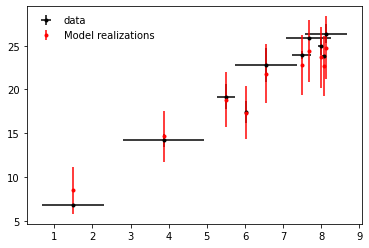

In [11]:
sim = [model(random.normal(loc=myoutput.beta,scale=myoutput.sd_beta),x) for i in range(100)]
mean_model = mean(sim,0)
std_model = std(sim,0)
pl.errorbar(x1,y,ye,xe,fmt='k.',label='data')
pl.errorbar(x1,mean_model,std_model,fmt='r.',label='Model realizations')
pl.legend(frameon=False)

So as a result of your fit, you end up with two set of points where both data and model have some uncertainties with magnitude which basically reflects how far you are from a deterministic case when you need no statistics. 
Note that uncertainties in data are reflected by uncertainties in the model and vice-versa. 
In this sense, fitting of a model to the data (and estimating uncertainty for model parameters) amounts to search for model realization which, when accounting for uncertainties, gives somethig maximally similar to data points, i.e. comparison of two distributions. Which is, of course, can fundamentally be done only via *conditional probabilites*, i.e. application of ***Bayes theorem***. Anything else you can do (any statistics you come up with to characterize scatter of your points etc) ultimately reduces to conditional probabilities, so large fraction of the community believes that's the way to go. They call it...

# Bayesian analysis

The basic idea here is the same as before, i.e. calculate the probability of our model given our data and maximize that to find optimal solution. There's a fundamental difference, however. In bayesian analysis it is assumed that model parameters are true random variables which we want characterize, and must be treated as such. That effectively means that in the plot above instead of the black errorbars (data uncertainties), red errorbars (model uncertainties) define fit statistics. That mith be counterintuitive, but this statement is equivalent to statement that **measurements have no errors**! If you think of it, it makes sense as when you measure something, it's really just a number (*outcome of experiment*) and available estimates of uncertainties are based on repetition of experiment, which means that you actually fit not data points, but collection of data points in traditional approach. The problem bayesian people see with it is that you need to assume some *distribution* of errors for each point in this case (i.e. *normal* in most case), which is not always really justified (and can be wrong). Anyway, what is the alternative? Go back to the roots! (just one step from axioms). We know that the probability of our model given our data is given by *bayes theorem*:
$$
P(\theta|D) = \frac{P(D|\theta)P(\theta)}{P(D)}
$$
here the basic probabilities are (***common name***)
* $P(D|\theta)$ the probability of the data given the model (***likelihood***)
* $P(\theta)$ the probability of our model (***prior***)
* $P(D)$ the probability of the data (***evidence***)
*likelihood* is basically equivalent to $\chi^2$ in traditional sense, *prior* reflects any prior knowledge on what your model parameters shall be (parameter space), and *evidence* or *global evidence* is the trickiest of them all as it basically defines the probability integral for all possible model combinations and is expensive (=hard) to compute. It is only required, however, when you want to asses goodness of your fit in absolute terms, which is not always required (and still possible). Speaking of integrals, to compute all three probabilities you need to calculate integrals of your statistics over possible combination of parameters (to come from frequency of occurence to probability you need to normalize the former to 1). Integration is normally done numerical with lots of tricks to speed process up, with most common alghoritms based on so-called *Markov-Chain Monte Carlo chains*. MCMCs are a class of methods that most broadly are used to numerically perform multidimensional integrals which are used to calculate the integrals we need and as such are often considered as a method to fit the data (not true!).
MCMC is, most simply, a *sampler* to probe as much of the parameter space as needed. That is to sample from the posterior distribution around optimum values found by other methods (gradient descent etc) in order to generatively model the data. This allows you to obtain more robust uncertainties on your parameters and understand multi-modalities or covariances in your data in a computationally effective way.

The fundamental process of running an MCMC in this mode is to compare generated models against data. Those models are generated by a set of parameters, and our goal is usually to sample from the set of parameters that produces the models that fit our data. It’s important to note that in order to be feasible, the MCMC process is inherently Bayesian as opposed to frequentist. What this means, practically, is that our MCMC requires us to impose what are known as priors on our parameters. These priors encode information we as modelers think we already know about the system we are modeling. For example, if I were constructing a model for the sun, I might impose a prior that the temperature at the core is within a certain range, because I know from observations that nuclear fusion is occurring, and that this can only happen above certain temperatures.

In practice what an MCMC does is allow you to estimate (sample) the posterior distribution (***likelihood***) of your data by numerical integration of right side of bayes theorem equation above by sampling it well enough for integral to remain accurate enough (that's subjective, but there are ways to check that *enough* is reached which are used in such alghoritms). From practical perspective to setup MCMC you need:

* Establish a function that outputs a model given a set of input parameters
* Establish an ensemble of *walkers* (samplers) defined by parameter vector $\theta$ that contains a set of parameters as used by the model-generating function. 
* Set boundaries for parameters $\theta$ (priors)
* Every walker can now begin exploring the parameter space. To do this, each walker takes a “step” to a new value of $\theta$ and generates a model with that it then compares the model to the given data, usually via a simple $\chi^2$ type check to calculate likelihood. Note that it is not really important how exactly likelihood calculated as it is in the end normalized to 1, i.e. re-defined. It must still be a representative metric of "distance" in outcome space (i.e. can not be random, but must be proportional to change in quality of the fit somehow).
* The MCMC then checks the ratio of the likelihood generated by the new model with the data vs. the current model. If the new location produces a better match to the data, the walker moves there and repeats the process. If the new location is worse, it retreats to its previous position and tries a new direction. Sometimes, even when a new position is good, the walker stays put, or if the new position is bad, the walker goes — this is set by what’s called the *acceptance* ratio, and it makes sure that walkers don’t all get trapped on individual peaks of high probability
* Eventually, the walkers all begin climbing towards the regions of highest “likeness” between the models generated in the data.

At the end of the process, we have what is known as a posterior distribution or chain. Every walker keeps a record of every $\theta$ vector it accepted, and the likelihood of the model given the data at that value of $\theta$.
By some complicated mathematics I won’t get into, this distribution, assuming the MCMC runs long enough to converge reasonably (that is, the distribution of walkers is not changing en masse as a function of step number), represents a sample of reasonable models to describe our data. It’s reasonable to wonder what the "best fit" is. But rememeber that MCMC is not a “fitter,” it is a “sampler.” MCMC can’t tell us that parameter set $\theta$ is the "best" - one our models will have the numerically highest value of likelihood to the data, but if we re ran the MCMC, or ran it longer, etc., we will get different answers. What MCMC is better at telling us is something like "If you draw 100 random models out of the posterior distribution, the spread in those models is representitive of our ability to constrain the parameters in those models." To say where the *best fit* is you need to calculate *global evidence* which is hard. If you ever need to, look for keywords like *Importance Nested Sampling*, *Ultranest*, and similar. Now let's focus on a practica example instead. I will use *emcee* package here, but there are many others which can do the same and more. I like *MultiNest* or *UltraNest* by by Johannes Buchner. Anyway, how do we proceed? We do have data and model defined already, so will just re-use those here. To proceed with MCMC we just need import the modules and define our *likelihood* function. For $\chi^2$ we could use scipy.stats to calculate it directly, but $e^{-\chi^2}$ is often a good enough approximation. Note that In practice most often log-likelihood is used for numerical reasons, so we can simplyfy our expression:

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10)

lnlike = lambda p, x, y, yerr: log(exp(-sum(((model(p,x)-y)/yerr)**2)))
# is the same as 
lnlike = lambda p, x, y, yerr: -sum(((model(p,x)-y)/yerr)**2)

another thing which has to be defined is function checking whether our *priors* are satisfied. In the case of *emcee* it can be arbitrary function which returns yes/no answer, i.e. 0 if all priors are satisfied, and *-np.inf* if not. The *lnlike* and *lnprior* are then combined to a single function *lnprob* which tells how probable is our realization considering our data and priors. We do not impose any constrains on parameters, so

In [13]:
lnprior = lambda p, x: 0.0
lnprob = lambda p, x,y,yerr: lnprior(p,x)==0 and lnlike(p,x,y,yerr) or -inf

This is basically equivalent our *cost function* to minimize, i.e. similar to $\chi^2$, but it takes also any possible priors into account. In principle, you can define it in a different way, i.e. to account for more/less probable combinations of parameters according to prior knowledge (complex priors returning not 0/inf, but rather some probability). Finally, we need to decide on how many walkers do we need and set-up starting point for each walker from where our fit will start. That's called *proposal*. There are many recipes both for number of walkers, and for proposals which ensures that fit is converged and minimum is sampled well enough in meaningful time, but we'll not discuss it here (in case of trouble go for more walkers and broader proposal range). Here we use (arbitrary) 16 walkers and *gaussian* proposal around expected value of parameters. Here we also define number of steps for chain to run (also go for more in case of doubt)

In [14]:
nwalkers = 32
niter = 1000
p0 = [random.normal(loc=[2,1],scale=1) for i in range(nwalkers)]
ndim = shape(p0)[1] # dimensionality of the problem

In *emcee* we need to define also final *main* function (can be differentnly named) which includes all definitions from the above:

In [15]:
def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)
    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()
    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)
    return sampler, pos, prob, state

The sampler here contains all the outputs of the MCMC, including the walker chains and the posteriors. We will talk a little bit later about evaluating whether an MCMC has “converged,” but for now let’s quickly extract a random sampling of our posteriors and plot them over our data.

In [16]:
data = (x,y,ye)
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...
Running production...


Now we can visualize the results. Remember that basic idea of MCMC is to sample parameter space, i.e. get an *aposteriori* estimate for distribution of model parameters which describe data well. The values of these can be accessed via the sampler object, here using *flatchain* attribute

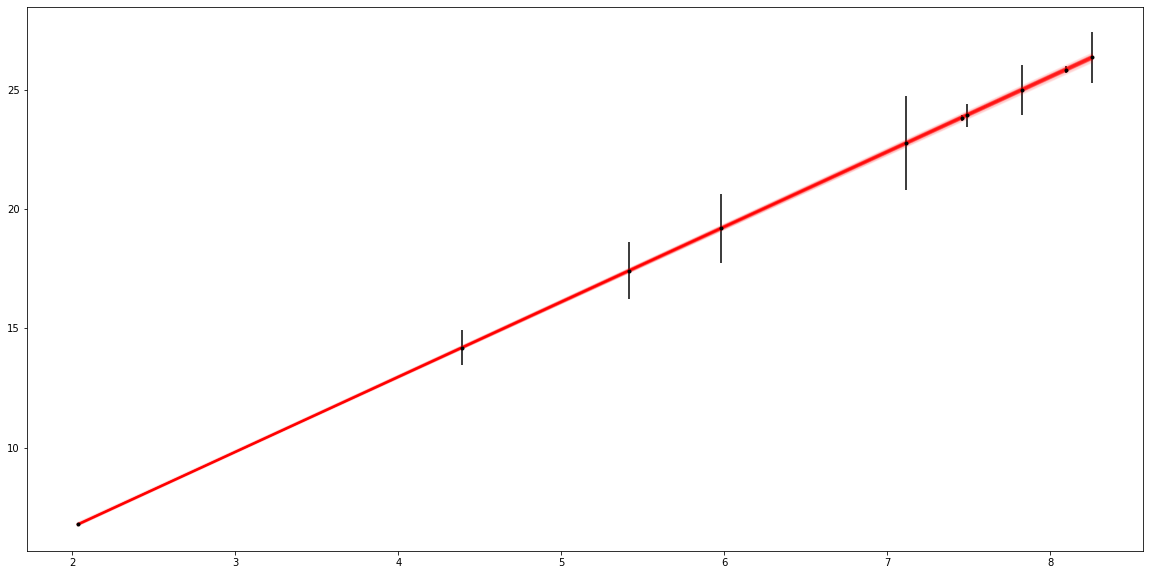

In [17]:
plt.errorbar(x,y,ye,fmt='k.')
samples = sampler.flatchain
for theta in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(x, model(theta, x), color="r", alpha=0.05)
plt.show()


You can also get an idea of how individual parameters are distributed by applying *descriptive* statistics methods, i.e. plotting histograms, or printing mean/std/quantiles (i.e. whatever you're interested in)

Estimated slope=3.15+/-0.01 (was 3.15)
Estimated intercept=0.37+/-0.04 (was 1.300000)


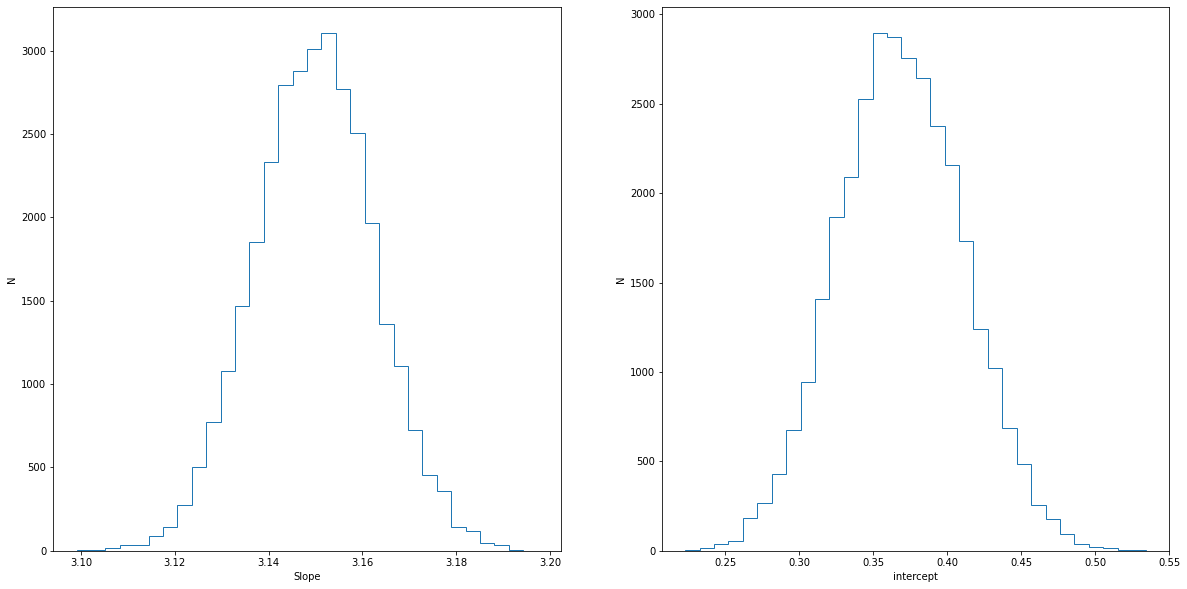

In [18]:
intercept,slope = transpose(sampler.flatchain)
plt.subplot(121)
r=plt.hist(slope,32,histtype='step')
plt.xlabel('Slope')
plt.ylabel('N')
plt.subplot(122)
r=plt.hist(intercept,32,histtype='step')
plt.xlabel('intercept')
plt.ylabel('N')
print("Estimated slope=%.2f+/-%.2f (was %.2f)"%(mean(slope),std(slope),slope0))
print("Estimated intercept=%.2f+/-%.2f (was %2f)"%(mean(intercept),std(intercept),intercept0))

Another common way to visualize MCMC results is through so-called corner plots. In python most easily produced using *corner* module

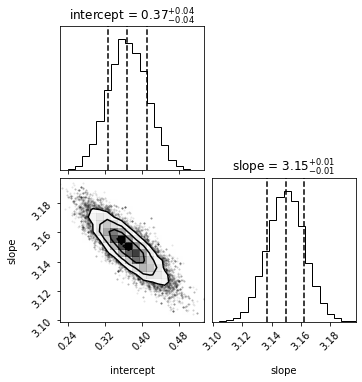

In [19]:
import corner
labels = ['intercept','slope']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

Note that it is quite similar to what sherpa produces as contour plots in our case. Also note quantiles printed in the title of each plot. You can get the same numbers directly from your samples (do that!). That might not be so for more complex cases with more complex inter-dependence of various parameters though! The MCMC alghoritms tend to sample parameter space around the fit better than you can do using projection, and often more effectively from also computational point of view. The more important difference is, however, that in MCMC no assumption is made about nature of errors in individual data points. They *are* typically used when calculating likelihood to weight good points more heavily, but they are *not* used to calculate critical values for $\Delta\chi^2$ (where normal uncertainties are usually assumed). In simulation we did both the deviations from ground truth and uncertainties are actually normal, so that's not an issue, however it can be. For instance, when working with counting-limited data (poisson), errors are defintively not normal. Also if you significantly underestimate or over-estimate errors this leads to problems with normal $\chi^2$ fitting. For istance, you might not know what systematic errors of your data are. Let's illustrate by repeating *sherpa* fit with much larger errors than actual scatter is. Note that we only modify uncertainty here, not the data itself. Note how much estimated uncertainties have increased!

Dataset               = 1
Method                = levmar
Statistic             = chi2
Initial fit statistic = 3.14287e-28
Final fit statistic   = 4.7922e-32 at function evaluation 4
Data points           = 10
Degrees of freedom    = 8
Probability [Q-value] = 1
Reduced statistic     = 5.99025e-33
Change in statistic   = 3.14239e-28
   pp.c0          0.368458     +/- 6.93702     
   pp.c1          3.15         +/- 0.927033    
pp.c0 lower bound:	-20.811
pp.c0 upper bound:	20.811
pp.c1 lower bound:	-2.7811
pp.c1 upper bound:	2.7811
Dataset               = 1
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = chi2gehrels
confidence 3-sigma (99.73%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   pp.c0            0.368458      -20.811       20.811
   pp.c1                3.15      -2.7811       2.7811


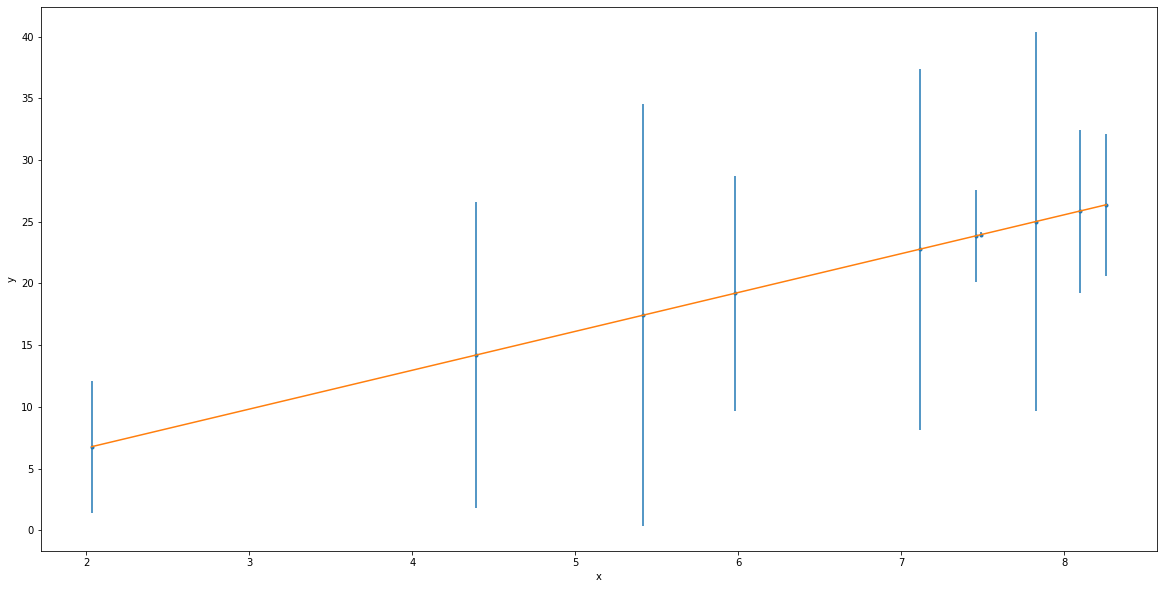

In [20]:
ui.load_arrays(1,x,y,10*ye+5)
ui.set_model(1,ui.polynom1d.pp)
ui.thaw(pp.c1)
ui.fit()
ui.conf()
ui.plot_fit()

If you *decrease* uncertainties (equivalent to underestimating your true errors in the data), which will reduce the uncertainties for best-fit parameters, but may lead to large $\chi^2$. In this case *sherpa* will complain as it is clear that if your $\chi^2_{red}>>1$ something is obviously wrong with the fit. You can test it yourself. Note that while you can make sherpa (or other $\chi^2$ based fit) to still calculate the parameter errors, those will be wrong because assumption under which corresponding critical levels were calculated under assumption that residuals follow standard normal distribution! Now, let's repeat same excercise with *emcee*

Running burn-in...
Running production...


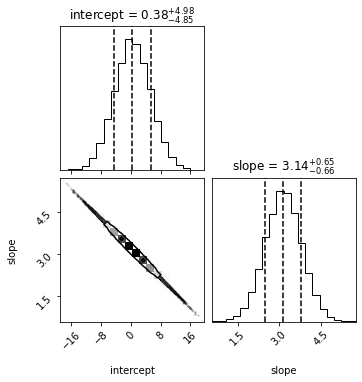

In [21]:
data = (x,y,10*ye+5)
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)
samples = sampler.flatchain
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

Note that while errors did increase a bit, it's not nearly as much as for $\chi^2$ fit. That's because MCMC only used assumed errors for weighting and uses aposteriori likelihood for all acceptable samples to calculate confidence intervals for parameters of interest. New data considering errors allows for more options, but not much mode, so MCMC yields lower errors. That's the main reason to use it.
One obvious problem with MCMC is that there's no obvious way to assess whether your fit is *good* in absolute terms. That's because to answer this question you need to integrate likelihood not only around your best fit, but also for the entire parameter space (all possible values of $\theta$) which is computationally expensive. You can do it, but actually in most cases we are not interested whether given model produces best possible fit, but rather whether one model is better than another (also considering possibly different number of free parameters in both).

# Model comparison
That question is actually more complex than appears at first sight. To illustrate this, take it to extreme, i.e. assume that your model contains same number of free parameters as you have points, i.e. just encodes values of your data points directly. In this case your model by definition matches your data perfectly, but that's not particularly useful :) One can guess, therefore, that there must be some balance, i.e. the model must be simple enough to sufficiently reduce dimensionality of the problem (originally defined by number of your data points), and yet still provide a good fit. When words *enough* or *sufficient* appear, one can immideately say that answer will be subjective, and it is indeed the case. In practice, empirical criteria have been developed to address this question, two most common ones are ***Bayesian information criterion (BIC)*** and ***Akaike information criterion (AIC)*** which are actually closely related. Botha are i.e. criteria for model selection among a finite set of models; the model with the lowest BIC/AIC is preferred. The BIC is formally defined as
$$
BIC=k\ln{n}-2\ln{\hat{L}}
$$
where $\hat{L}$ is your maximized likelihood for given model (for instance, from MCMC), $n$ is number of your data points, and $k$ is number of free parameters in your model. Similarly, AIC is defined as
$$
AIC = 2k - 2\ln{\hat{L}}
$$
both criteria rely on some clever approximations of the likelihood space (not discussed here), and the main difference is that AIC tries to select the model that *most adequately* describes an unknown, high dimensional reality whereas BIC tries to find the *true* model among the set of candidates. As a result, BIC is more appropriate to use when you need to select among several models whereas AIC is more of a *goodness of fit* metrics. That said, they produce similar results in most cases, so it makes sense to calculate both and then reflect on what you get and why can it be. 

## How to use in practice?
For AIC, you can calculate AIC for all *optimized* models you want to compare, and then quantity $\exp{((AIC_{min} − AIC_i)/2)}$ can be interpreted as probability that model $i$ minimizes the estimated loss of information (due to introduction of some additional model parameters). On the other hand, for BIC you can also calculate $\Delta$BIC with respect to the best model, and then interpret this value using empirical criteria, i.e. if you get slightly smaller BIC for a more complex model

$\Delta$BIC=0-2 - not worth a mention; 
$\Delta$BIC=2-6 - positive indication that complex model is preferred;
$\Delta$BIC=6-10 - strong indication that complex model is preferred;
$\Delta$BIC=>10 - very strong indication that complex model is preferred.

let us try to apply both to our data, but now we introduce second model, i.e. try to fit our linear dependence with a quadratic model. This means we need to redifine also our likelihood function and some other stuff

Running burn-in...
Running production...


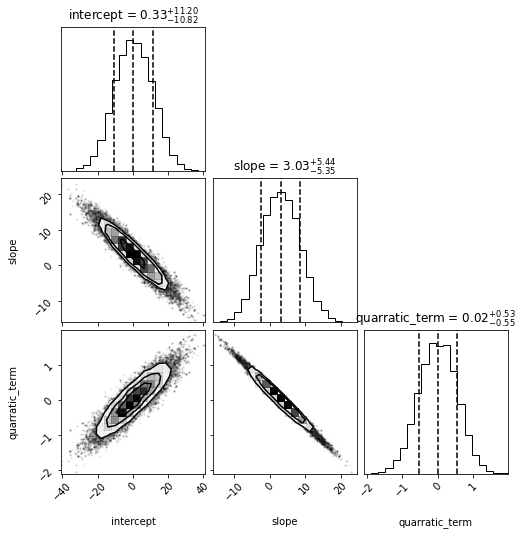

In [22]:
complex_model = lambda p, x: p[0]+p[1]*x+p[2]*x**2
complex_lnlike = lambda p, x, y, yerr: -sum(((complex_model(p,x)-y)/yerr)**2)
complex_lnprob = lambda p, x,y,yerr: lnprior(p,x)==0 and complex_lnlike(p,x,y,yerr) or -inf
complex_p0 = [random.normal(loc=[2,1,0],scale=1) for i in range(nwalkers)]
ndim = shape(complex_p0)[1] # dimensionality of the problem
complex_sampler, complex_pos, complex_prob, state = main(complex_p0,nwalkers,niter,ndim,complex_lnprob,data)
complex_samples = complex_sampler.flatchain
complex_labels = ['intercept','slope','quarratic_term']
fig = corner.corner(complex_samples,show_titles=True,labels=complex_labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

First of all, note that now we have more panels here to reflect inter-dependence between all parameters. 2nd thing to note is that your quadratic term is consistent with 0, and uncertainties for other parameters increased again. That's because similarly to the case before when larger errors of your data allowed more flexibility, now additional flexibility is provided by more complex model. That is, you introduced parameter which is not really needed, i.e. lost some information! Now we can calculate AIC/BIC for both models

In [23]:
AIC = lambda k,L: 2*k-2*log(L)
BIC = lambda k,n,L: k*log(n)-2*log(L)
BIC_DESCRIPTION = lambda deltaBIC: deltaBIC<2 and "very weak" or deltaBIC<6 and "weak" or deltaBIC<10 and "strong" or "very strong"
simple_min = min(sampler.flatlnprobability)
complex_min = min(complex_sampler.flatlnprobability)
models = ('simple','complex')
bics = (BIC(2,len(x),10**simple_min),BIC(3,len(x),10**complex_min))
deltabic=max(bics)-min(bics)
print("BICs for two models are %f and %f"%bics)
print("%s model is preferred"%models[argmin(bics)])
print("significance of this preferece is %s"%(BIC_DESCRIPTION(deltabic)))
aics=(AIC(2,10**simple_min),AIC(3,10**complex_min))
print("On the other hand, AICs are %f and %f"%aics)
print("Corresponding probabilities that given model is preferred", exp((min(aics)-array(aics))/2.))

BICs for two models are 50.195628 and 60.389598
simple model is preferred
significance of this preferece is very strong
On the other hand, AICs are 49.590458 and 59.481842
Corresponding probabilities that given model is preferred [1.         0.00711399]


Note that the probability for AIC in the later case is 1, and it will always be like that for the best model. It does not mean, however, that you can be 100% sure that the model describes your data. To say this you would need to compute so-called *global evidence*, i.e. full integral over all combinations. This can be done i.e. with MultiNest or similar. You can, however, use AIC/BIC to choose between two models. There are also similar ways to choose between ***nested*** models when you're using normal $\chi^2$, i.e. f-test and MLR test (maximum likelihood ratio test). Those have their own limitations and shall not be overvalued when working with real data.

# The takeaway
You might remember that 99% of all statical analyses uses conventional $\chi^2$ statistics even if it is, strictly speaking, generally bad practice. The reason why people still use it is that ***it is good enough*** and ***gives the same results as bayes approach*** in vast majority of cases. You can mess-up with it, but you can also mess-up with bayesian analysis. Poor choice of priors or likelihood function will give wrong results! Bayes and MCMC are not magic words and silver bullets! Use your common sense and learn statistics, this will help to decide.